In [1]:
from normalizers.GAS_norm import SD_Normalization_Student, Update_function_Student
from normalizers.RevIN import RevIN
from pytorch_forecasting.data import NaNLabelEncoder, TorchNormalizer, EncoderNormalizer
from utils.data_prep import prepare_dataset
from models.GAS_LSTM import AR_GAS

from pytorch_forecasting.data.examples import generate_ar_data
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

c:\Users\euret\anaconda3\envs\pytorc_forecasting\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
#generate ar_data
ar_data = generate_ar_data(seasonality=20.0, timesteps=5000, n_series=1, seed=42)
ar_data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(ar_data.time_idx, "D")
ar_data = ar_data.astype(dict(series=str))

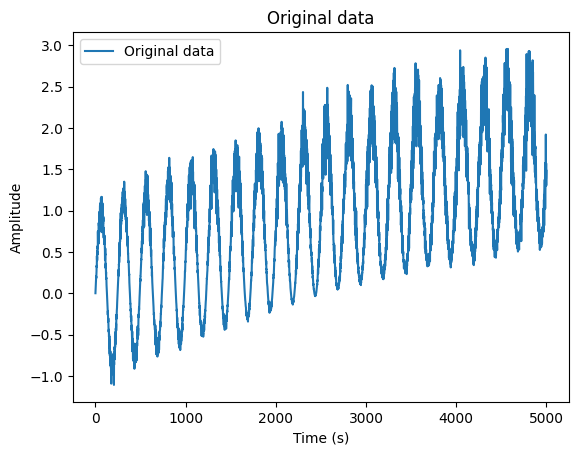

In [3]:
batch_selection = 1

# Parameters
max_encoder_length = 100
max_prediction_length = 50
batch_size = 128
mean_norm_strength = 0.05
var_norm_strength = 0.05
degrees_freedom = 100
norm_strength = [mean_norm_strength, var_norm_strength]
normalizer_choice = EncoderNormalizer()

#pass args as named tuple
args = namedtuple("args", ["max_encoder_length", "max_prediction_length", "batch_size",  "normalizer_choice"])
args = args(max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length, 
            batch_size=batch_size,  normalizer_choice=normalizer_choice)

training, valdiation, test, gas_params = prepare_dataset(ar_data,use_gas_normalization=False, args=args, norm_strength=norm_strength, degrees_freedom=degrees_freedom,)

Mean: -0.6517417430877686, Computed Mean: -0.6517417430877686
Std: 0.2599552869796753, Computed Std: 0.25995516777038574


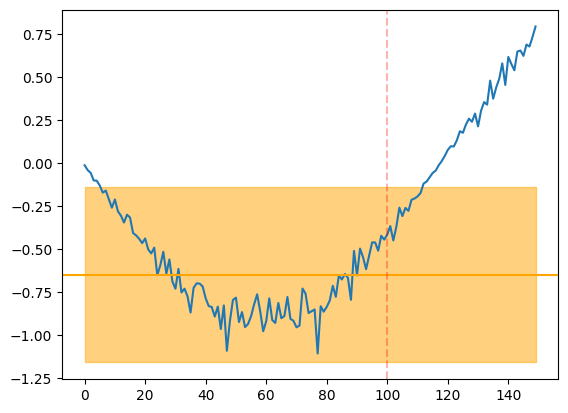

In [4]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)

for i, batch in enumerate(train_dataloader):
    if i == batch_selection:
        break


enc_target = batch[0]['encoder_target'][0]
mean_enc = batch[0]['target_scale'][0,0]
std_enc = batch[0]['target_scale'][0,1]
computed_mean = enc_target.mean()
computed_std = enc_target.std()


print(f"Mean: {mean_enc}, Computed Mean: {computed_mean}")
print(f"Std: {std_enc}, Computed Std: {computed_std}")


dec_target = batch[0]['decoder_target'][0]

#concatenate encoder and decoder target
target = torch.cat([enc_target, dec_target], dim=0)

#plot the enc_target and the computed mean and std
#plot the enc_target and the computed mean and std
plt.plot(target)
plt.axhline(y=mean_enc, color='orange', linestyle='-')
#Fille the 95% confidence interval
plt.fill_between(range(len(target)), mean_enc-1.96*std_enc, mean_enc+1.96*std_enc, color='orange', alpha=0.5)
plt.axvline(x=max_encoder_length, color='r', linestyle='--', alpha=0.3)
plt.show()


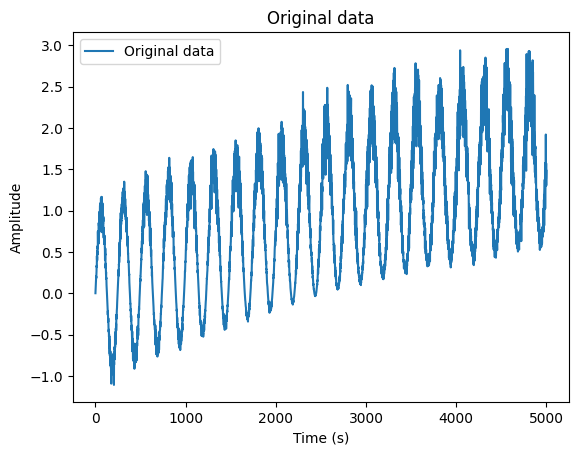

In [5]:
args = namedtuple("args", ["max_encoder_length", "max_prediction_length", "batch_size",  "normalizer_choice"])
normalizer_choice = TorchNormalizer()
args = args(max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length, 
            batch_size=batch_size,  normalizer_choice=normalizer_choice)


training, valdiation, test, gas_params = prepare_dataset(ar_data,use_gas_normalization=False, args=args, norm_strength=norm_strength, degrees_freedom=degrees_freedom,)

Mean: 0.690664923016112, Computed Mean: -0.6517417430877686
Std: 0.7786107123102309, Computed Std: 0.25995516777038574


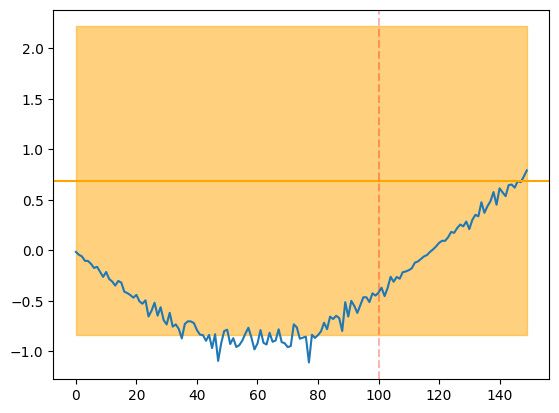

In [6]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)

for i, batch in enumerate(train_dataloader):
    if i == batch_selection:
        break

enc_target = batch[0]['encoder_target'][0]
mean_enc = batch[0]['target_scale'][0,0]
std_enc = batch[0]['target_scale'][0,1]
computed_mean = enc_target.mean()
computed_std = enc_target.std()


print(f"Mean: {mean_enc}, Computed Mean: {computed_mean}")
print(f"Std: {std_enc}, Computed Std: {computed_std}")


dec_target = batch[0]['decoder_target'][0]

#concatenate encoder and decoder target
target = torch.cat([enc_target, dec_target], dim=0)

#plot the enc_target and the computed mean and std
#plot the enc_target and the computed mean and std
plt.plot(target)
plt.axhline(y=mean_enc, color='orange', linestyle='-')
#Fille the 95% confidence interval
plt.fill_between(range(len(target)), mean_enc-1.96*std_enc, mean_enc+1.96*std_enc, color='orange', alpha=0.5)
plt.axvline(x=max_encoder_length, color='r', linestyle='--', alpha=0.3)
plt.show()


Optimal parameters:  alpha_mu = 0.9999338930386481,  alpha_sigma = 0.9999338930386481, beta_mu = 0.9920596194247644, beta_sigma = 0.3923089810846726, omega_mu = 0.0055921045117081234, omega_sigma = 0.0556524833527517, mu_0 = 0.3093685410670047, sigma2_0 = 0.033004260285273535


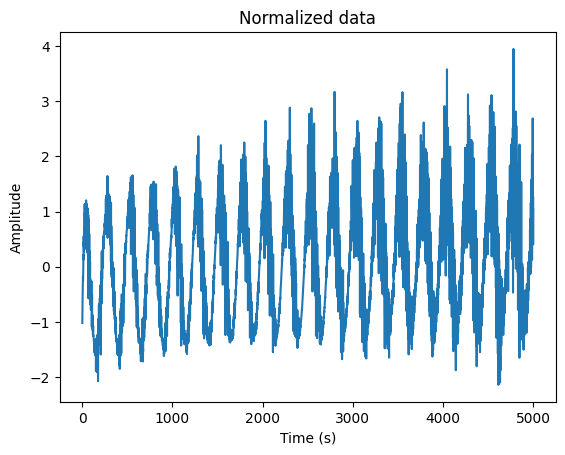

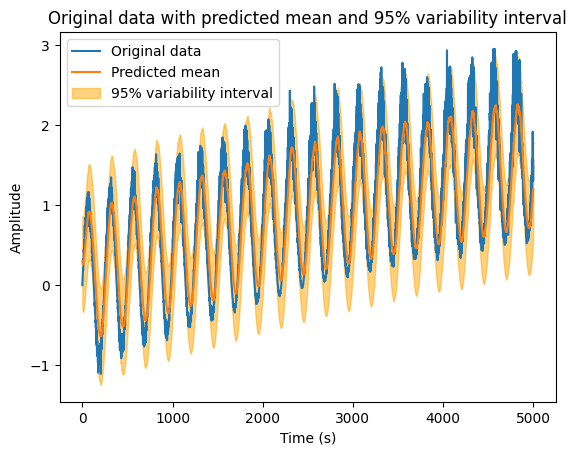

In [7]:
args = namedtuple("args", ["max_encoder_length", "max_prediction_length", "batch_size",  "normalizer_choice"])
normalizer_choice = TorchNormalizer(method = 'identity', center = False)
args = args(max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length, 
            batch_size=batch_size,  normalizer_choice=normalizer_choice)


training, valdiation, test, gas_params = prepare_dataset(ar_data,use_gas_normalization=True, args=args, norm_strength=norm_strength, degrees_freedom=degrees_freedom,)

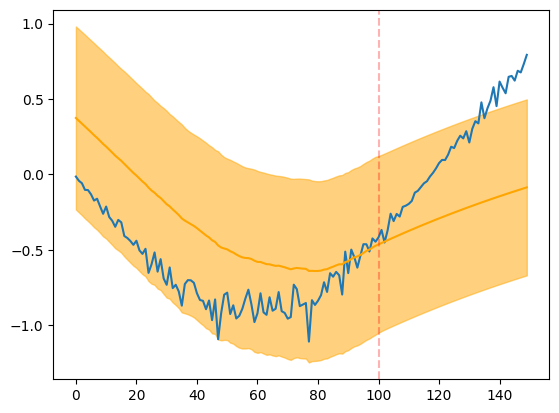

In [8]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)

for i, batch in enumerate(train_dataloader):
    if i == batch_selection:
        break


enc_target = batch[0]['encoder_target'][0] 
mean_enc = batch[0]['encoder_cont'][0, :, 0]
var_enc = batch[0]['encoder_cont'][0, :, 1]


dec_target = batch[0]['decoder_target'][0]
mean_dec = batch[0]['decoder_cont'][0, :, 0]
var_dec = batch[0]['decoder_cont'][0, :, 1]

ar_gas = AR_GAS(max_prediction_length)
pred_mean, pred_std = ar_gas.forward(mean_enc[-1], var_enc[-1], gas_params)
std_enc = torch.sqrt(var_enc)


#concatenate encoder and decoder target and mean and var
target = torch.cat([enc_target, dec_target], dim=0)
mean = torch.cat([mean_enc, pred_mean], dim=0)
std = torch.cat([std_enc, pred_std], dim=0)



#plot the enc_target and the computed mean and std
plt.plot(target)
plt.plot(mean, color='orange', linestyle='-')

plt.fill_between(range(len(target)), mean-1.96*std, mean+1.96*std, color='orange', alpha=0.5)
plt.axvline(x=max_encoder_length, color='r', linestyle='--', alpha=0.3)
plt.show()



## VIX DATA

In [9]:
###############################
#Download the VIX index from yahoo finance
import yfinance as yf

vix = yf.download("^VIX")

#Compute the returns of the VIX index
vix['Adj Close'] = vix['Adj Close'].diff()
vix = vix.dropna()


#Construct Pandas dataframe with the VIX index, the Date, a time index starting from 0 and a series column to identify the series

vix = vix.reset_index()
vix['time_idx'] = vix.index
vix['series'] = 0
#Change column name
vix = vix.rename(columns={'Adj Close':'value', 'Date':'date'})
#Drop columns
vix = vix.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

#Add an outlier to the VIX index in the position 150
vix.loc[3, 'value'] = -20

c:\Users\euret\anaconda3\envs\pytorc_forecasting\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


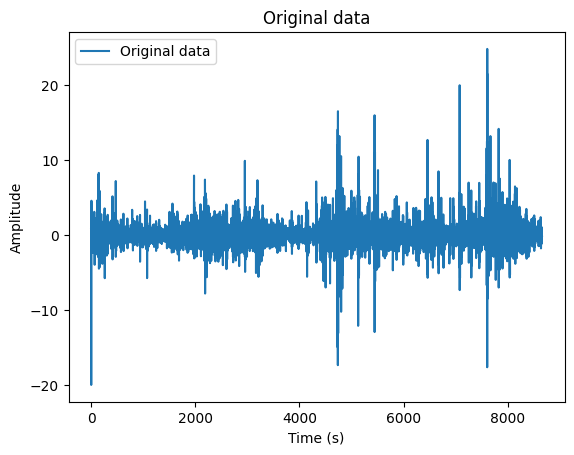

In [10]:
batch_selection = 0

# Parameters
max_encoder_length = 5
max_prediction_length = 10
batch_size = 128
mean_norm_strength = 0.5
var_norm_strength = 0.5
degrees_freedom = 20
norm_strength = [mean_norm_strength, var_norm_strength]
normalizer_choice = EncoderNormalizer()

#pass args as named tuple
args = namedtuple("args", ["max_encoder_length", "max_prediction_length", "batch_size",  "normalizer_choice"])
args = args(max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length, 
            batch_size=batch_size,  normalizer_choice=normalizer_choice)

training, valdiation, test, gas_params = prepare_dataset(vix, use_gas_normalization=False, args=args, norm_strength=norm_strength, degrees_freedom=degrees_freedom,)


Mean: -3.0379996299743652, Computed Mean: -3.0379996299743652
Std: 9.491731643676758, Computed Std: 9.491731643676758


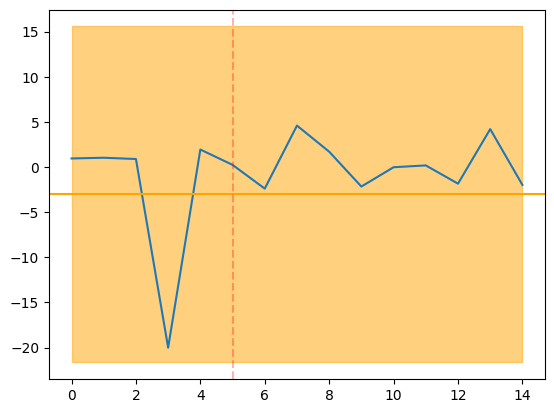

In [11]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)

for i, batch in enumerate(train_dataloader):
    if i == batch_selection:
        break


enc_target = batch[0]['encoder_target'][0]
mean_enc = batch[0]['target_scale'][0,0]
std_enc = batch[0]['target_scale'][0,1]
computed_mean = enc_target.mean()
computed_std = enc_target.std()


print(f"Mean: {mean_enc}, Computed Mean: {computed_mean}")
print(f"Std: {std_enc}, Computed Std: {computed_std}")


dec_target = batch[0]['decoder_target'][0]

#concatenate encoder and decoder target
target = torch.cat([enc_target, dec_target], dim=0)

#plot the enc_target and the computed mean and std
plt.plot(target)
plt.axhline(y=mean_enc, color='orange', linestyle='-')
#Fille the 95% confidence interval
plt.fill_between(range(len(target)), mean_enc-1.96*std_enc, mean_enc+1.96*std_enc, color='orange', alpha=0.5)
plt.axvline(x=max_encoder_length, color='r', linestyle='--', alpha=0.3)
plt.show()




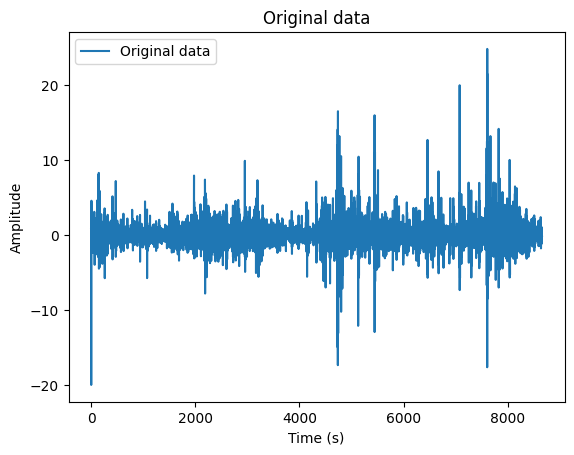

In [12]:
args = namedtuple("args", ["max_encoder_length", "max_prediction_length", "batch_size",  "normalizer_choice"])
normalizer_choice = TorchNormalizer()
args = args(max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length, 
            batch_size=batch_size,  normalizer_choice=normalizer_choice)


training, valdiation, test, gas_params = prepare_dataset(vix,use_gas_normalization=False, args=args, norm_strength=norm_strength, degrees_freedom=degrees_freedom,)

Mean: -0.0038957609981667106, Computed Mean: -3.0379996299743652
Std: 1.5569781289299292, Computed Std: 9.491731643676758


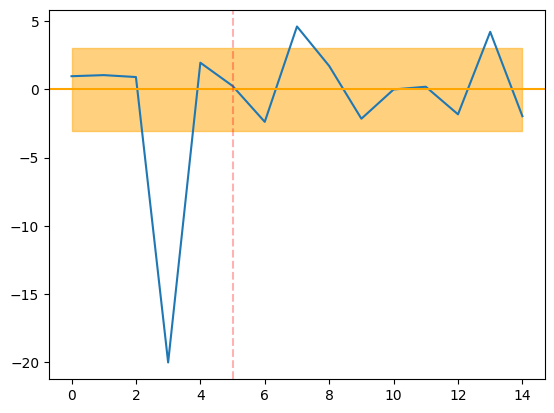

In [13]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)

for i, batch in enumerate(train_dataloader):
    if i == batch_selection:
        break

enc_target = batch[0]['encoder_target'][0]
mean_enc = batch[0]['target_scale'][0,0]
std_enc = batch[0]['target_scale'][0,1]
computed_mean = enc_target.mean()
computed_std = enc_target.std()


print(f"Mean: {mean_enc}, Computed Mean: {computed_mean}")
print(f"Std: {std_enc}, Computed Std: {computed_std}")


dec_target = batch[0]['decoder_target'][0]

#concatenate encoder and decoder target
target = torch.cat([enc_target, dec_target], dim=0)

#plot the enc_target and the computed mean and std
plt.plot(target)
plt.axhline(y=mean_enc, color='orange', linestyle='-')
#Fille the 95% confidence interval
plt.fill_between(range(len(target)), mean_enc-1.96*std_enc, mean_enc+1.96*std_enc, color='orange', alpha=0.5)
plt.axvline(x=max_encoder_length, color='r', linestyle='--', alpha=0.3)
plt.show()


Optimal parameters:  alpha_mu = 6.610623995740123e-05,  alpha_sigma = 0.9999997946892245, beta_mu = 0.641910172290769, beta_sigma = 0.05661716631022838, omega_mu = -0.007926944850454308, omega_sigma = 1.321806579165864, mu_0 = 0.9047036027075168, sigma2_0 = 1.3219248917421018


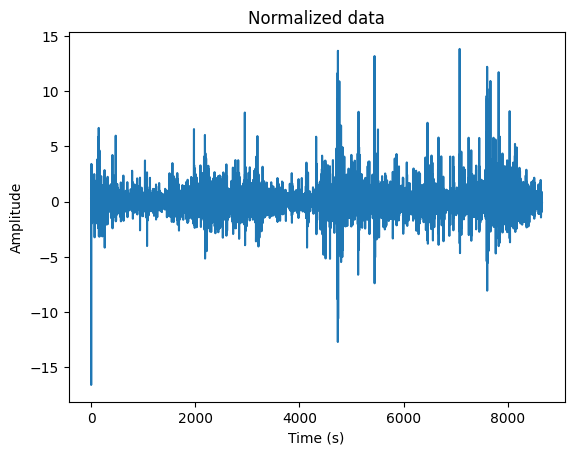

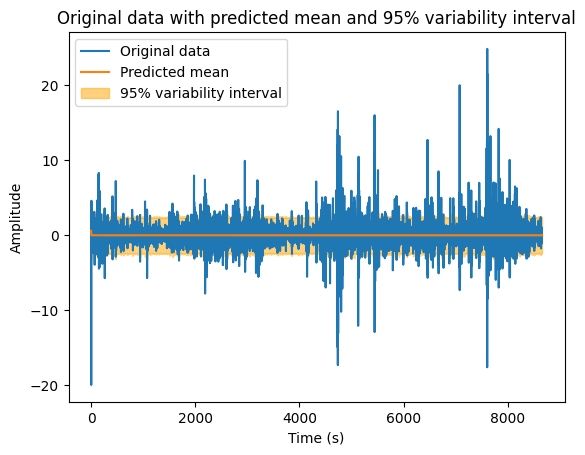

In [14]:
args = namedtuple("args", ["max_encoder_length", "max_prediction_length", "batch_size",  "normalizer_choice"])
normalizer_choice = TorchNormalizer(method = 'identity', center = False)
args = args(max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length, 
            batch_size=batch_size,  normalizer_choice=normalizer_choice)


training, valdiation, test, gas_params = prepare_dataset(vix,use_gas_normalization=True, args=args, norm_strength=norm_strength, degrees_freedom=degrees_freedom,)

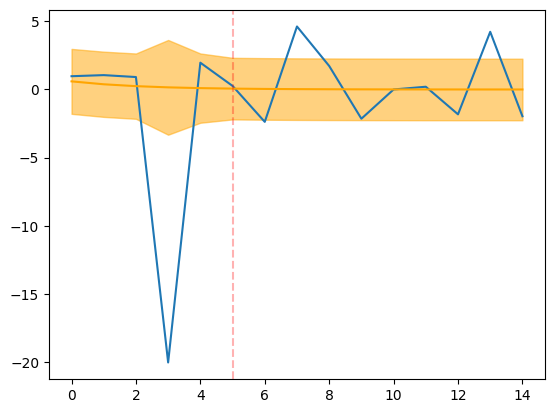

In [15]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)

for i, batch in enumerate(train_dataloader):
    if i == batch_selection:
        break


enc_target = batch[0]['encoder_target'][0] 
mean_enc = batch[0]['encoder_cont'][0, :, 0]
var_enc = batch[0]['encoder_cont'][0, :, 1]


dec_target = batch[0]['decoder_target'][0]
mean_dec = batch[0]['decoder_cont'][0, :, 0]
var_dec = batch[0]['decoder_cont'][0, :, 1]

ar_gas = AR_GAS(max_prediction_length)
pred_mean, pred_std = ar_gas.forward(mean_enc[-1], var_enc[-1], gas_params)
std_enc = torch.sqrt(var_enc)


#concatenate encoder and decoder target and mean and var
target = torch.cat([enc_target, dec_target], dim=0)
mean = torch.cat([mean_enc, pred_mean], dim=0)
std = torch.cat([std_enc, pred_std], dim=0)



#plot the enc_target and the computed mean and std
#plot the enc_target and the computed mean and std
plt.plot(target)
plt.plot(mean, color='orange', linestyle='-')
plt.fill_between(range(len(target)), mean-1.96*std, mean+1.96*std, color='orange', alpha=0.5)
plt.axvline(x=max_encoder_length, color='r', linestyle='--', alpha=0.3)
plt.show()